# 1. The Problem

ClassPass sells a recurring monthly subscriptoin that acts like a gym membership. ClassPass's memberes can use its website and mobile app to book unlimited boutqiue fitness studios in 34 cities across the globe. 

For a subscription businesse, it is extremly important to decrease the percent of users that cancel each month. Users that cancel are called churners in subscription lingo. It is important to minimize churn so revenue grows each month as new users sign up (i.e. if the same amount of people cancel and sign-up for ClassPass within a month the business will not have grown month over month). If the number of cancels exceeds the number of new user adds within a month the business will be shrinking month over month.

It would be beneficial to flag users that are at risk of churning and send them targeted marketing materials (personal attention from a customer service agent, discounts for future months, special booking privileges, etc.). These targeted message would hopefully convince the user to stay on the platform longer.

My goal is to predict which users are at risk for churning before the end of their first month. It is is beneficial to predict churn earlier in a users first month to give ClassPass's markeitng more time to convince users not to cancel.


# 2. EDA

For this project I generated a dataset of ClassPass subscriber aquisitions that contains the following features: 
* City
* Paid or unpaid source
* Promo or non-promo offer
* \# of classes Attended in the 7 days
* \# of classes attended in the 14 days 
* \# of classes attended in the 21 days 
* \# of tier-1 classes attnded in the 7 week 
* \# of tier-1 classes attnded in the 14 days 
* \# of tier-1 classes attnded in the 21 days 

To preprocess the data I manipulated my features to create the following:
* k-1 boolean features for each city
* is_promo (bool)
* is_paid (bool)
* \# of classes attended in the first week 
* \# of classes attended in the second week
* \# of classes attended in the third week
* \# of tier 1 classes attended in the first week
* \# of tier 1 classes attended in the second week
* \# of tier 1 classes attended in the third week

My data set has ~165K rows and 42 features. Of the total data set ~15% have churned. This indicates I have unbalanced labels. 

In [33]:
d, df1 = load_data()
df1.shape

(165319, 42)

In [27]:
print('percent churned: ', df1.is_churned.sum()/df1.shape[0]*100, '%')

percent churned:  15.0412233319 %


The median number of classes taken for users that remain on the platform after 1 month is higher than the users that churn after 1 month. Below is a box plot comparison of all users thrid week of classes split by churners and on churners.

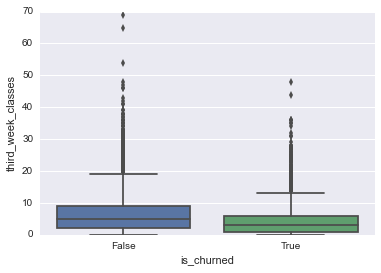

In [28]:
ax = sns.boxplot(x='is_churned', y='third_week_classes', data=df1)

In [36]:
# calculate % of tier 1 classes in a users first month
df1['total_classes_attended'] = df1['first_week_classes'] + df1['second_week_classes'] + df1['third_week_classes']
df1['total_tier1_classes'] = df1['first_week_tier_1_classes'] + df1['second_week_tier_1_classes'] + df1['third_week_tier_1_classes']
df1['percent_tier_1'] = df1.total_tier1_classes/df1.total_classes_attended


The median number of premium, or Tier 1, studios that a non churned user attends is higher than the median number of tier 1 studios that a churned user attends.

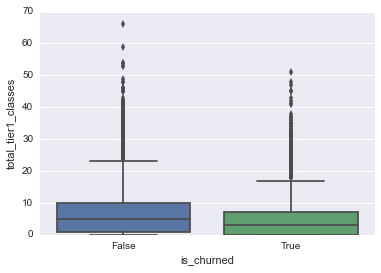

In [39]:
ax = sns.boxplot(x='is_churned', y='total_tier1_classes', data=df1)

# 3. Model Tuning 

To select the appropriate hyper parameters for each model I first split the data into two folds in a 8:2 ratio. I used 20% of the data in a gridsearch to determine the best hyperparameters for my model.

In [40]:
X_train, X_test, y_train, y_test = split_data(d)
estimators = tune_model(X_test, y_test)


 GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': (0.01, 0.1, 1)}, pre_dispatch='2*n_jobs',
       refit=True, score_func=None, scoring='recall', verbose=0)
best params
 {'C': 1}
best_score
 0.000199493414871

 GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=Non

# 4. Model Scoring

To score the model, I used the remaining 80% of the data and calculated accuracy, AUC-ROC, and recall using cross validation. ~15% of the records are positive for the target category (churn). 

Noting that my labels are imbalanced I focused on the recall and AUC-ROC metric for scoring. In addition, I am most interested in recall given the business application of this model (correctly predicitng whol will churn).

In [41]:
score_model(X_train, y_train, estimators)


 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

cv results
 [ 0.84994896  0.84991116  0.84987335  0.84994896  0.84983554]

mean cv accuracy = 0.849903595327
std cv accuracy =  4.40887066262e-05

cv scores ROC
 [ 0.6765952   0.66801801  0.67697396  0.67231286  0.68210751]

mean cv ROC = 0.675201508759
std cv ROC = 0.00474812891527

cv scores Recall
 [ 0.00050365  0.00050365  0.00075548  0.0010073   0.00025183]

mean cv Recall = 0.000604381767817
std cv Recall = 0.00025681286898

 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
 

# 5. Feature Importance 

I ran a feature importance evaluation to see if week 1 or week 2 classes had a high enough importance to run the model at an earlier timepoint (without any of the later data).

Althought the features for the number of classes attended each week and the number of tier 1 classes attended each week were of the highet importance, the total importance for the features at week 1 or week 2 is not high enough to run the model early.

In [43]:
fit_model(d['feature'], d['labels'], estimators)


 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

feature importnace

feature               importance
Austin                 0.00688680856727
Baltimore                 0.00211842843876
Boston                 0.0106141513063
Charlotte                 0.00413292288839
Chicago                 0.0101754606653
Columbus                 0.00308401653817
Dallas/Fort Worth                 0.00812364761872
Denver                 0.00710896127189
Houston                 0.00595960866721
Kansas City                 0.00482254529347
Las Vegas                 0.00224488380897
London                 0.00241671644218
Los Angeles/Orange County                 0.00792439926335
Melbourne              

# 6. Next Steps

In its current state my recall score is very low. To enhance my recall, I can have my model output the probability of churning instead of a boolean. From there I can lower the threshold value that will classify someone to be at risk for churning. 

In addition, ClassPass works to mature its beahavioral data collection capabilites, it will be useful to layer additinoal features such as:
* Days since last login 
* Number of logins 
* Is mobile app downloaded?
* Number of reservations made on the app
* Number of resrvation cancellations 
* Number of missed classes 

# 7. Implementation

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
import sklearn.cross_validation as cv
from sklearn.linear_model import LogisticRegression
import sklearn.grid_search as gs
import seaborn as sns
%matplotlib inline

DATA  = '~/Desktop/project1.csv'
COLS = ['user_id', 'msa_id', 'city_name', 'user_source', 'is_promo_user', 
'is_churned_after_first_period', 'classes_attended_in_first_7_days', 
'classes_attended_in_first_14_days', 'classes_attended_in_first_21_days', 
'tier_1_classes_attended_in_first_7_days', 'tier_1_classes_attended_in_first_14_days', 
'tier_1_classes_attended_in_first_21_days']
N_FOLDS = 5



def load_data(input_file=DATA):

	df0 = pd.read_csv(DATA, sep = ',', header=0, names = COLS)
	
	#### Create dummy variables for city variable 
	df1 = pd.concat(([df0, pd.get_dummies(df0['city_name'])]), axis=1)
	
	### Create boolean for is_promo, is_paid, is_churned
	df1['is_churned'] = df1.is_churned_after_first_period.apply(lambda k: k == 'Yes')
	df1['is_promo'] = df1.is_promo_user.apply(lambda k: k == 'Yes')
	df1['is_paid'] = df1.user_source.apply(lambda k: k == 'paid')
	
	### Create variables for classes each week
	df1['first_week_classes'] = df1['classes_attended_in_first_7_days']
	df1['second_week_classes'] = df1['classes_attended_in_first_14_days'] 
	- df1['classes_attended_in_first_7_days']
	df1['third_week_classes'] = df1['classes_attended_in_first_21_days'] 
	- df1['classes_attended_in_first_14_days']

	### Create variable for tier 1 classes each week 
	df1['first_week_tier_1_classes']  = df1['tier_1_classes_attended_in_first_7_days']
	df1['second_week_tier_1_classes'] = df1['tier_1_classes_attended_in_first_14_days'] 
	- df1['tier_1_classes_attended_in_first_7_days']
	df1['third_week_tier_1_classes'] = df1['tier_1_classes_attended_in_first_21_days'] 
	- df1['tier_1_classes_attended_in_first_14_days']

	### Drop excess variables 
	df1.drop(['Atlanta', 'user_id', 'msa_id', 'city_name', 'is_churned_after_first_period', 
		'is_promo_user','user_source', 'classes_attended_in_first_7_days',
		'classes_attended_in_first_14_days', 'classes_attended_in_first_21_days', 
		'tier_1_classes_attended_in_first_7_days', 'tier_1_classes_attended_in_first_14_days',
		'tier_1_classes_attended_in_first_21_days'], inplace=True, axis=1)

	features = df1.drop(['is_churned'], axis=1)
	labels = df1['is_churned']

	d = {'feature': features, 'labels': labels}

	return d, df1

def split_data(data):

	(X_train, X_test, y_train, y_test) = cv.train_test_split(data['feature'], data['labels'], test_size=0.2, random_state=0)
	return X_train, X_test, y_train, y_test

def tune_model(x, y):

	#RFC_params = {'max_depth':(10, 20, 50),'n_estimators':[100, 500, 1000], 'max_features':['sqrt', 'log2'], 'n_jobs':[-1]}
	#GBC_params = {'n_estimators':[100,500,1000]}


	LR_params = {'C':(0.01, 0.1, 1)}
	RFC_params = {'max_depth':(5, 10, 50, 100),'n_estimators':[5, 10, 50, 100], 'max_features':['sqrt', 'log2'], 'n_jobs':[-1]}
	GBC_params = {'n_estimators':[100, 500, 1000]}

	models = LogisticRegression(), RFC(), GBC()
	params = LR_params, RFC_params, GBC_params

	estimators = list()
	# hyper_params = dict()

	for m, p in zip(models, params):
		optimized = gs.GridSearchCV(m, p, scoring='recall', cv = 3) 
		optimized.fit(x, y)
		print('\n==========\n', optimized)
		print('best params\n', optimized.best_params_)
		print('best_score\n', optimized.best_score_)

		# hyper_params[key] = optimized.best_score_
		estimators.append(optimized.best_estimator_)
		# print('hyper_params =', hyper_params)

	return estimators

def score_model(x, y, est):

	for e in est:

		cv_results = cv.cross_val_score(e, x, y, cv = N_FOLDS)
		cv_scores_roc = cv.cross_val_score(e, x, y, cv = N_FOLDS, scoring='roc_auc')
		cv_recall = cv.cross_val_score(e, x, y, cv = N_FOLDS, scoring='recall')
		print('\n==========\n', e)
		print('\ncv results\n', cv_results)
		print('\nmean cv accuracy =', cv_results.mean())
		print('std cv accuracy = ', cv_results.std())
		print('\ncv scores ROC\n', cv_scores_roc)
		print('\nmean cv ROC =', cv_scores_roc.mean())
		print('std cv ROC =', cv_scores_roc.std())
		print('\ncv scores Recall\n', cv_recall)
		print('\nmean cv Recall =', cv_recall.mean())
		print('std cv Recall =', cv_recall.std())

def fit_model(x, y, est):

	features_names = list(x.columns.values)

	for e in est[1:]:
		e.fit(x,y)
		feature_impt = e.feature_importances_
		print('\n==========\n', e)
		print('\nfeature importnace')
		print('\nfeature               importance')
		for i in range(x.shape[1]):
			print(features_names[i],'               ',feature_impt[i])